In [60]:
import requests
import os
import zipfile
import pandas as pd
import re
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, TruncatedSVD

# Baixando arquivos

In [4]:
url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
url2 = "https://files.grouplens.org/datasets/movielens/ml-1m-README.txt"
local_filename = "ml-1m.zip"
local_readme = "ml-1m-README.txt"

In [3]:
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(local_filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [5]:
with requests.get(url2, stream=True) as response:
    response.raise_for_status()
    with open(local_readme, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

In [13]:
extract_dir = os.path.dirname(os.path.abspath(local_filename))

In [14]:
with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Manipulação de dados

In [2]:
file_path1 = "ml-1m/ratings.dat"
file_path2 = "ml-1m/movies.dat"

In [3]:
ratings = pd.read_csv(file_path1, sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [4]:
movies = pd.read_csv(file_path2, sep='::', engine='python', header=None, names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')

In [5]:
movies['Genres'] = movies['Genres'].str.replace('|', ',')

In [6]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),"Animation,Children's,Comedy"
1,2,Jumanji (1995),"Adventure,Children's,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama"
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies['Year'] = movies['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)

In [8]:
null_counts = movies.isnull().sum()
null_counts

MovieID    0
Title      0
Genres     0
Year       0
dtype: int64

In [9]:
null_counts = ratings.isnull().sum()
null_counts

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [10]:
num_users = ratings['UserID'].nunique()
num_users

6040

In [11]:
num_movies = movies['MovieID'].nunique()
num_movies

3883

In [12]:
df_genres = movies.copy()
df_genres = df_genres.drop('Genres', axis=1).join(movies['Genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Genre'))

/home/savio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


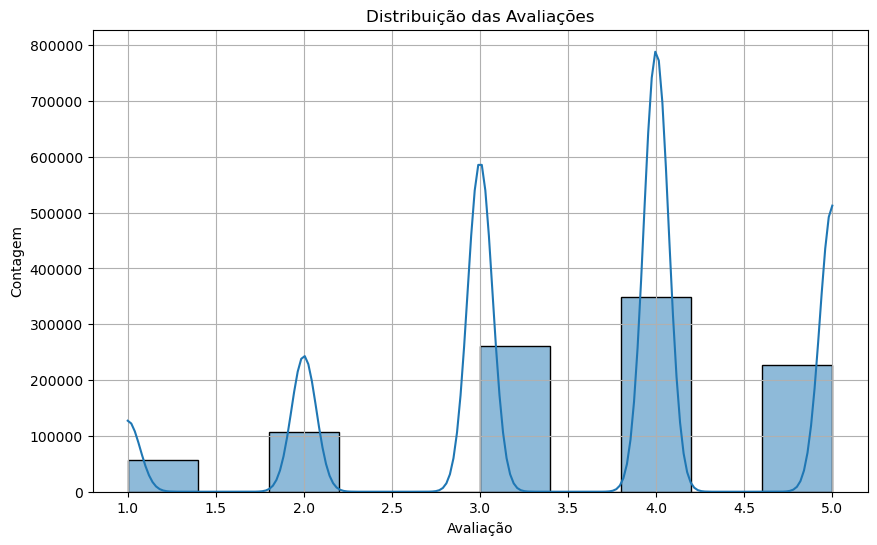

In [13]:
# 1. Distribuição das Avaliações
plt.figure(figsize=(10, 6))
sns.histplot(ratings['Rating'], bins=10, kde=True)
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.grid(True)
plt.show()

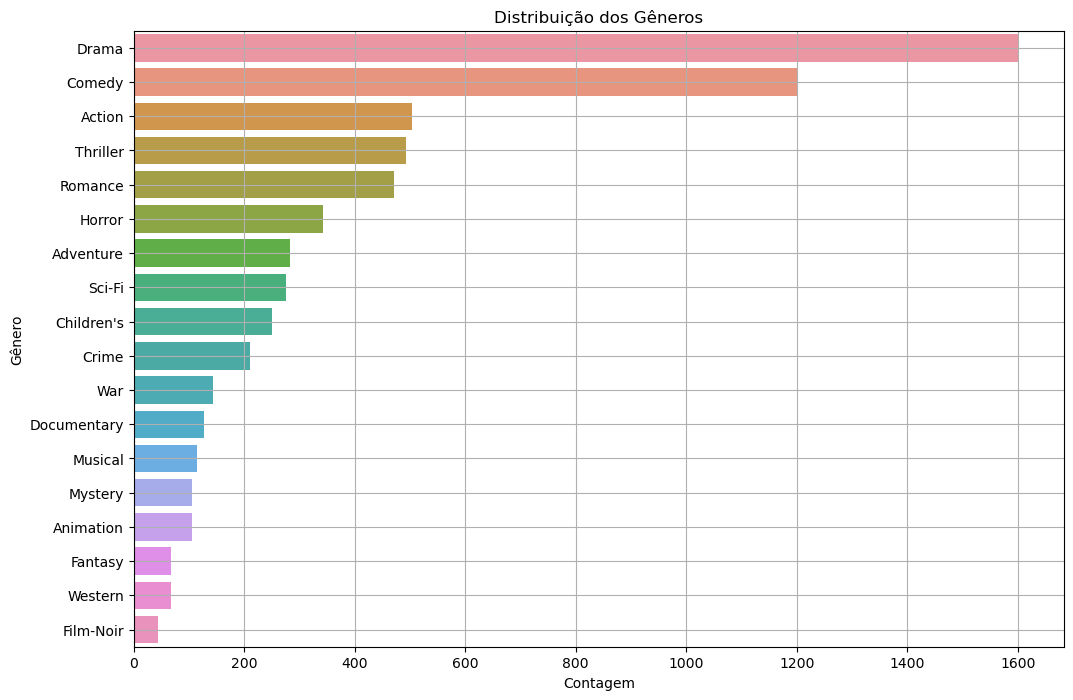

In [14]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Genre', data=df_genres, order = df_genres['Genre'].value_counts().index)
plt.title('Distribuição dos Gêneros')
plt.xlabel('Contagem')
plt.ylabel('Gênero')
plt.grid(True)
plt.show()

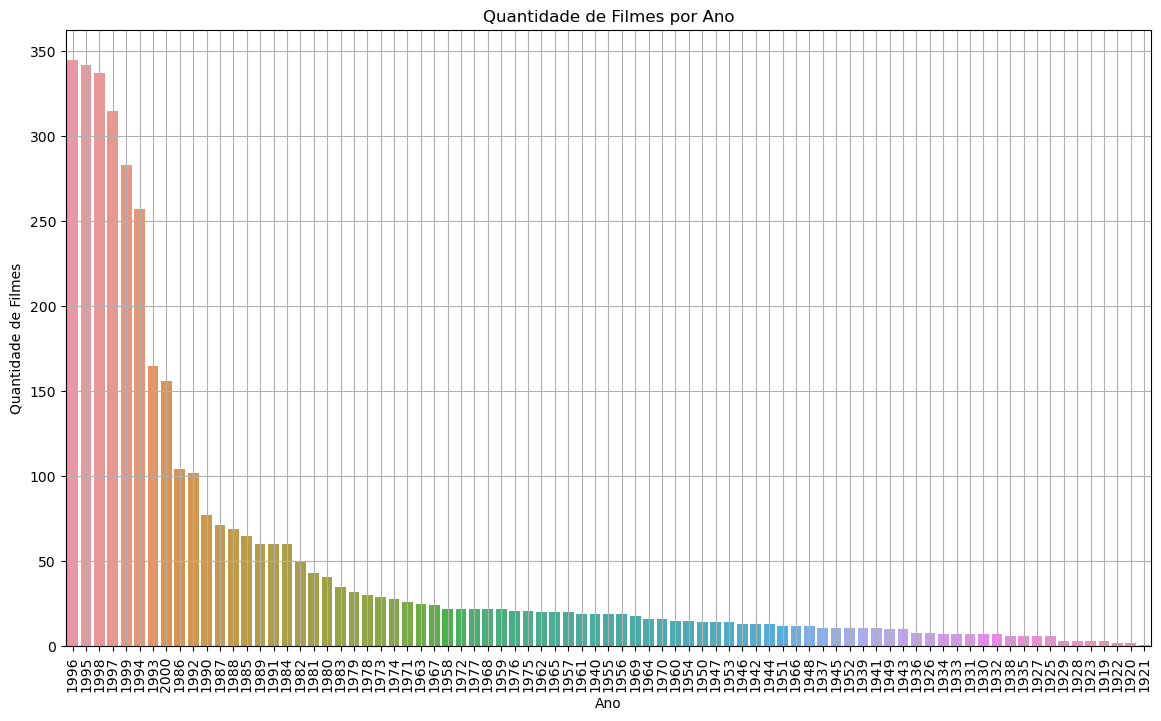

In [15]:
plt.figure(figsize=(14, 8))
sns.countplot(x='Year', data=movies, order = movies['Year'].value_counts().index)
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Filmes')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Pré-processamento dos dados:

In [16]:
duplicated_ratings = ratings[ratings.duplicated()]

In [17]:
if not duplicated_ratings.empty:
    print("Valores duplicados encontrados:")
    print(duplicated_ratings)
else:
    print("Não há valores duplicados nas avaliações.")

Não há valores duplicados nas avaliações.


In [18]:
movies_in_ratings = movies[movies['MovieID'].isin(ratings['MovieID'])].copy()

In [19]:
movies_in_ratings['MovieIDTrue'] = range(1, len(movies_in_ratings) + 1)

In [20]:
ratings = ratings.merge(movies_in_ratings[['MovieID', 'MovieIDTrue']], on='MovieID', how='left')

In [21]:
num_movies = movies_in_ratings['MovieIDTrue'].nunique()
num_movies

3706

In [22]:
ratings_matrix = np.empty((num_movies, num_users))

In [23]:
ratings_matrix[:] = np.nan

In [24]:
for index, row in ratings.iterrows():
    ratings_matrix[row['MovieIDTrue']-1][row['UserID']-1] = row['Rating']

In [25]:
ratings_matrix

array([[ 5., nan, nan, ..., nan, nan,  3.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [26]:
def replace_nans_with_row_mean(matrix):
    for i in range(matrix.shape[0]):
        row = matrix[i, :]
        mean_value = np.nanmean(row)
        row[np.isnan(row)] = mean_value
    return matrix

In [27]:
ratings_matrix = replace_nans_with_row_mean(ratings_matrix)

In [28]:
ratings_matrix

array([[5.        , 4.14684641, 4.14684641, ..., 4.14684641, 4.14684641,
        3.        ],
       [3.20114123, 3.20114123, 3.20114123, ..., 3.20114123, 3.20114123,
        3.20114123],
       [3.0167364 , 3.0167364 , 3.0167364 , ..., 3.0167364 , 3.0167364 ,
        3.0167364 ],
       ...,
       [3.66666667, 3.66666667, 3.66666667, ..., 3.66666667, 3.66666667,
        3.66666667],
       [3.9       , 3.9       , 3.9       , ..., 3.9       , 3.9       ,
        3.9       ],
       [3.78092784, 3.78092784, 3.78092784, ..., 3.78092784, 3.78092784,
        3.78092784]])

In [29]:
def normalize_row(row):
    mean = np.mean(row)
    std = np.std(row)
    mean = np.nanmean(row)
    std = np.nanstd(row)
    if std == 0:
        return np.zeros_like(row)  # Substituir por zeros se o desvio padrão for zero
    return (row - mean) / std
    return (row - mean) / std

In [30]:
ratings_matrix_normalized = np.apply_along_axis(normalize_row, 1, ratings_matrix)

In [31]:
total_nans = np.isnan(ratings_matrix_normalized).sum()
print(f"Número total de NaNs: {total_nans}")

Número total de NaNs: 0


In [32]:
ratings_matrix_normalized

array([[ 1.70731838e+00,  1.77740956e-15,  1.77740956e-15, ...,
         1.77740956e-15,  1.77740956e-15, -2.29505214e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.53184131e-15,  4.53184131e-15,  4.53184131e-15, ...,
         4.53184131e-15,  4.53184131e-15,  4.53184131e-15],
       [ 5.22691510e-15,  5.22691510e-15,  5.22691510e-15, ...,
         5.22691510e-15,  5.22691510e-15,  5.22691510e-15],
       [ 5.62870295e-15,  5.62870295e-15,  5.62870295e-15, ...,
         5.62870295e-15,  5.62870295e-15,  5.62870295e-15]])

# Matriz de distâncias

In [34]:
dist_matrix = pdist(ratings_matrix_normalized, metric='euclidean')

In [35]:
dist_matrix_square = squareform(dist_matrix)

In [36]:
dist_matrix_square

array([[  0.        , 105.69494673, 107.3649446 , ..., 109.17594079,
        109.26922304, 108.33532832],
       [105.69494673,   0.        , 107.94088516, ..., 110.57554306,
        110.26061826, 109.60542063],
       [107.3649446 , 107.94088516,   0.        , ..., 108.46084939,
        108.92857814, 109.09574796],
       ...,
       [109.17594079, 110.57554306, 108.46084939, ...,   0.        ,
        107.70125075, 106.18090639],
       [109.26922304, 110.26061826, 108.92857814, ..., 107.70125075,
          0.        , 103.6646929 ],
       [108.33532832, 109.60542063, 109.09574796, ..., 106.18090639,
        103.6646929 ,   0.        ]])

# Kmeans

In [37]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42}

In [38]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 81):
   print(k)
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs, )
   kmeans.fit(ratings_matrix_normalized)
   sse.append(kmeans.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


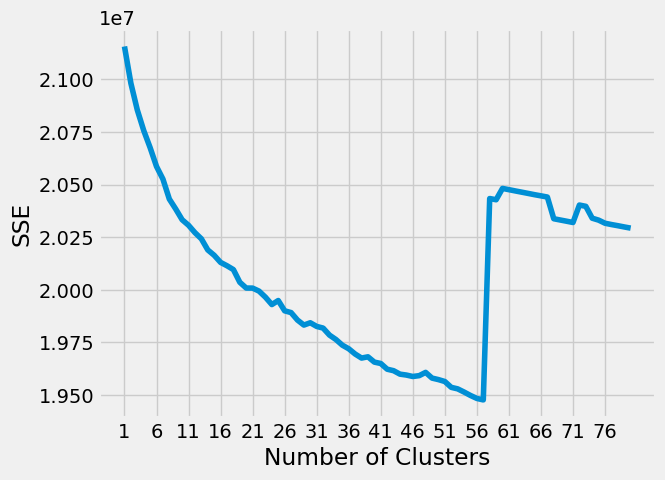

In [77]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 81), sse)
plt.xticks(range(1, 81, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [40]:
kl = KneeLocator(range(1, 81), sse, curve="convex", direction="decreasing")

In [41]:
kl.elbow

20

Verificou-se um ponto de cotovelo epor volta de 20, mas 20 emsi deu resultados bee ruins na clusterização, então aproximei por 21

In [65]:
kmeans = KMeans(n_clusters=21, random_state=42, n_init = 10)
kmeans_clusters = kmeans.fit_predict(ratings_matrix_normalized)

In [73]:
movies_in_ratings['KMeans_Cluster'] = kmeans_clusters

In [74]:
cluster_counts = movies_in_ratings['KMeans_Cluster'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 KMeans_Cluster
15    660
19    286
4     279
5     200
9     191
16    188
0     185
11    183
1     172
2     145
18    132
20    130
13    123
12    120
6     118
7     115
8     108
3     104
14    101
10     97
17     69
Name: count, dtype: int64


# Clustering Hierárquico

Usando um número de clusters semelhante ao K Means

In [69]:
agg_clustering = AgglomerativeClustering(n_clusters=21, affinity='precomputed', linkage='complete')
agg_clusters = agg_clustering.fit_predict(dist_matrix_square)

/home/savio/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [70]:
len(agg_clusters)

3706

In [75]:
movies_in_ratings['Hierarchical_Cluster'] = agg_clusters

In [76]:
cluster_counts = movies_in_ratings['Hierarchical_Cluster'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 Hierarchical_Cluster
0     757
5     475
11    430
9     236
8     211
2     204
7     192
10    161
4     160
6     145
1     141
19     91
17     80
14     73
15     69
18     67
3      57
13     48
20     41
16     39
12     29
Name: count, dtype: int64


## DBscan

In [263]:
eps = 20000
min_samples = 1

In [189]:
k = 5  # Ajuste conforme necessário
nbrs = NearestNeighbors(n_neighbors=k, metric='precomputed').fit(dist_matrix_square)
distances, indices = nbrs.kneighbors(dist_matrix_square)

# Ordenar as distâncias dos k-ésimos vizinhos mais próximos
k_distances = np.sort(distances[:, k-1], axis=0)

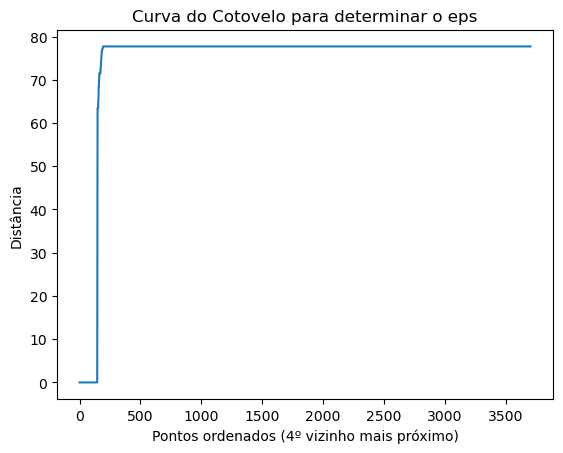

In [190]:
plt.plot(k_distances)
plt.xlabel("Pontos ordenados (4º vizinho mais próximo)")
plt.ylabel("Distância")
plt.title("Curva do Cotovelo para determinar o eps")
plt.show()

In [264]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')

In [265]:
dbscan_clusters = dbscan.fit_predict(dist_matrix_square)

In [266]:
len(movies_in_ratings['DBSCAN_Cluster'].unique())

1

In [267]:
cluster_counts = movies_in_ratings['DBSCAN_Cluster'].value_counts()
print("Contagem dos clusters formados:\n", cluster_counts)

Contagem dos clusters formados:
 DBSCAN_Cluster
-1    3706
Name: count, dtype: int64


# Número de clusters

No Kmeans, verificou-se que um valor ideal estava por volta de 20, onde começou uma queda mais acentuada.

Nocluster hierárquico usando 21 como número de clsuters tivemos clsuters bem populados, portanto foi uma boa estimativa

O dbscan não funcionou como esperado.

# Análise dos clusters

Vamos tentar identificar os clusters dos filmes de terror e ficção científica

In [82]:
generos_unicos = set()
for generos in movies['Genres']:
    for genero in generos:
        generos_unicos.add(genero)

In [86]:
generos_unicos = set()
for generos in movies['Genres']:
    for genero in generos.split(','):
        generos_unicos.add(genero.strip())
generos_unicos

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [88]:
cluster_genero_predominante_hierarchical = {}
cluster_genero_predominante_kmeans = {}

In [93]:
# Iterar sobre cada cluster
for cluster in movies_in_ratings['KMeans_Cluster'].unique():
    # Filtrar o DataFrame para o cluster atual
    cluster_df = movies_in_ratings[movies_in_ratings['KMeans_Cluster'] == cluster]
    
    # Inicializar um dicionário para contar a ocorrência de cada gênero
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    # Contar a ocorrência de cada gênero no cluster
    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    # Determinar o gênero predominante no cluster
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None  # Caso não haja gêneros, podemos definir como None ou outra coisa
    
    # Salvar o resultado no dicionário
    cluster_genero_predominante_kmeans[cluster] = (genero_predominante, porcentagem)

In [94]:
print(cluster_genero_predominante_kmeans)

{12: ("Children's", 97.5), 18: ('Action', 68.93939393939394), 7: ('Comedy', 57.391304347826086), 9: ('Drama', 62.82722513089005), 16: ('Comedy', 92.5531914893617), 19: ('Drama', 57.34265734265735), 1: ('Action', 73.25581395348837), 4: ('Drama', 62.72401433691756), 2: ('Drama', 48.96551724137931), 0: ('Drama', 54.59459459459459), 8: ('Romance', 50.0), 15: ('Drama', 50.0), 6: ('Comedy', 88.98305084745762), 13: ('Drama', 98.3739837398374), 20: ('Horror', 73.07692307692307), 3: ('Drama', 50.0), 17: ('Horror', 73.91304347826086), 11: ('Action', 50.81967213114754), 10: ('Comedy', 39.175257731958766), 14: ('Horror', 100.0), 5: ('Drama', 33.5)}


Foi possível encontrar o cluster do Horror

In [96]:
# Iterar sobre cada cluster
for cluster in movies_in_ratings['Hierarchical_Cluster'].unique():
    # Filtrar o DataFrame para o cluster atual
    cluster_df = movies_in_ratings[movies_in_ratings['Hierarchical_Cluster'] == cluster]
    
    # Inicializar um dicionário para contar a ocorrência de cada gênero
    genero_counts = {genero: 0 for genero in generos_unicos}
    
    # Contar a ocorrência de cada gênero no cluster
    total_filmes_no_cluster = len(cluster_df)
    for generos in cluster_df['Genres'].dropna():
        for genero in generos.split(','):
            if genero in genero_counts:
                genero_counts[genero] += 1
    
    # Determinar o gênero predominante no cluster
    if genero_counts:
        genero_predominante = max(genero_counts, key=genero_counts.get)
        porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
    else:
        genero_predominante = None  # Caso não haja gêneros, podemos definir como None ou outra coisa
    
    # Salvar o resultado no dicionário
    cluster_genero_predominante_hierarchical[cluster] = (genero_predominante, porcentagem)

In [97]:
print(cluster_genero_predominante_hierarchical)

{8: ('Comedy', 28.436018957345972), 0: ('Drama', 41.87582562747688), 5: ('Drama', 48.63157894736842), 11: ('Comedy', 37.2093023255814), 6: ('Drama', 44.827586206896555), 10: ('Comedy', 44.099378881987576), 17: ('Drama', 45.0), 7: ('Drama', 35.9375), 4: ('Drama', 38.125), 2: ('Drama', 38.72549019607843), 1: ('Drama', 52.4822695035461), 13: ('Drama', 100.0), 9: ('Horror', 25.0), 19: ('Drama', 49.45054945054945), 14: ('Drama', 53.42465753424658), 18: ('Drama', 61.19402985074627), 16: ('Drama', 58.97435897435898), 12: ('Drama', 58.620689655172406), 15: ('Drama', 42.028985507246375), 3: ('Comedy', 54.385964912280706), 20: ('Drama', 41.46341463414634)}


Percebe-se que o cluster teve pouca coerência interna

In [125]:
for cluster, (genero, porcentagem) in cluster_genero_predominante_db.items():
    if porcentagem >= 70:
        print(f"Cluster {cluster} possui {porcentagem}% das classificações no gênero {genero}")

Cluster 13 possui 75.0% das classificações no gênero Action
Cluster 32 possui 75.0% das classificações no gênero Adventure
Cluster 37 possui 72.97297297297297% das classificações no gênero Drama
Cluster 59 possui 70.0% das classificações no gênero Drama
Cluster 60 possui 82.8125% das classificações no gênero Drama
Cluster 68 possui 90.32258064516128% das classificações no gênero Comedy
Cluster 80 possui 77.5% das classificações no gênero Drama
Cluster 85 possui 80.64516129032258% das classificações no gênero Comedy
Cluster 144 possui 72.5% das classificações no gênero Drama
Cluster 164 possui 70.2127659574468% das classificações no gênero Drama
Cluster 181 possui 71.42857142857143% das classificações no gênero Drama


# Exclusão de outliers

Consideraremos um outlier como sendo um usuário que tem uma média de avaliação maior que 4,7, ou seja, só avalia os filmes positivamente, podendo ser um trol ou bancado por algum estúdio. Da mesma forma, retiramremos usuários com uma média de avaliações menor ou igual a 2.

In [33]:
user_mean_ratings = ratings.groupby('UserID')['Rating'].mean()

In [34]:
user_mean_ratings.head(10)

UserID
1     4.188679
2     3.713178
3     3.901961
4     4.190476
5     3.146465
6     3.901408
7     4.322581
8     3.884892
9     3.735849
10    4.114713
Name: Rating, dtype: float64

In [35]:
users_to_exclude = user_mean_ratings[(user_mean_ratings >= 4.7) | (user_mean_ratings <= 2)].index

In [36]:
users_to_exclude

Index([  91,  283,  446,  447,  682, 1131, 1670, 2339, 2744, 3324, 3461, 3598,
       3902, 4349, 4486, 4539, 4634, 4636, 4649, 4755, 4801, 4925, 5069, 5334,
       5768, 5850, 5984],
      dtype='int64', name='UserID')

In [37]:
ratings_filtered = ratings[~ratings['UserID'].isin(users_to_exclude)].copy()

Precisamos agora gerar novamente as matrizes.

In [38]:
movies_in_ratings = movies[movies['MovieID'].isin(ratings_filtered['MovieID'])].copy()

In [39]:
movies_in_ratings['MovieIDTrue'] = range(1, len(movies_in_ratings) + 1)

In [40]:
ratings_filtered.drop(columns=['MovieIDTrue'], inplace= True)

In [41]:
ratings_filtered = ratings_filtered.merge(movies_in_ratings[['MovieID', 'MovieIDTrue']], on='MovieID', how='left')

In [42]:
num_users = ratings_filtered['UserID'].nunique()
num_users

6013

In [43]:
num_movies = movies_in_ratings['MovieIDTrue'].nunique()
num_movies

3702

In [44]:
ratings_matrix = np.empty((num_movies, num_users))
ratings_matrix[:] = np.nan

In [45]:
unique_user_ids = ratings_filtered['UserID'].drop_duplicates().reset_index(drop=True)

In [46]:
unique_user_ids = pd.DataFrame(unique_user_ids)
unique_user_ids['UserIDTrue'] = range(1, len(unique_user_ids) + 1)

In [47]:
ratings_filtered = ratings_filtered.merge(unique_user_ids, on='UserID', how='left')

In [48]:
ratings_filtered.tail()

,UserID,MovieID,Rating,Timestamp,MovieIDTrue,UserIDTrue
998500,6040,1091,1,956716541,1018,6013
998501,6040,1094,5,956704887,1021,6013
998502,6040,562,5,956704746,547,6013
998503,6040,1096,4,956715648,1023,6013
998504,6040,1097,4,956715569,1024,6013


In [49]:
for index, row in ratings_filtered.iterrows():
    ratings_matrix[row['MovieIDTrue']-1][row['UserIDTrue']-1] = row['Rating']

In [50]:
ratings_matrix = replace_nans_with_row_mean(ratings_matrix)

In [51]:
ratings_matrix_normalized = np.apply_along_axis(normalize_row, 1, ratings_matrix)

In [52]:
total_nans = np.isnan(ratings_matrix_normalized).sum()
print(f"Número total de NaNs: {total_nans}")

Número total de NaNs: 0


# Calculando SVD e PCA

In [54]:
pca = PCA()
X_pca = pca.fit_transform(ratings_matrix_normalized)

In [55]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

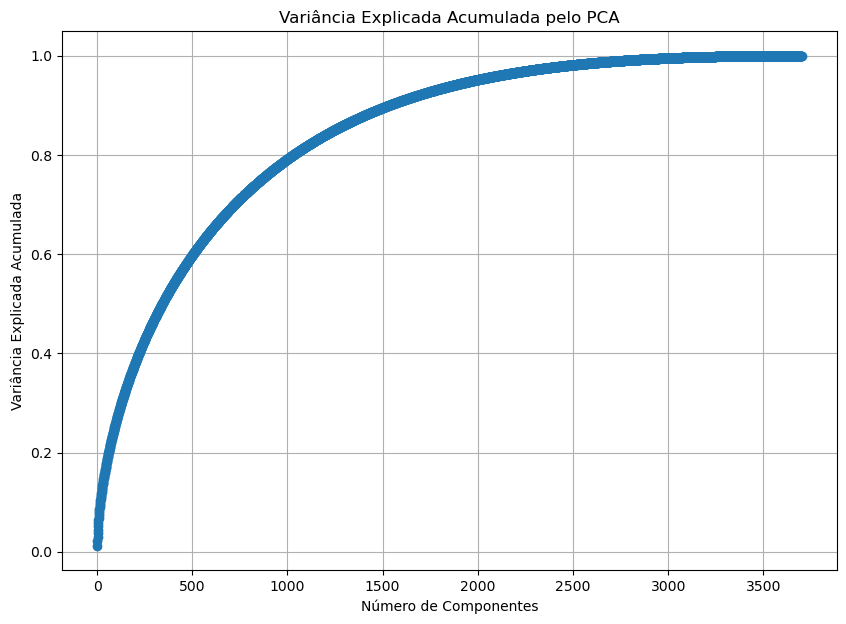

In [56]:
# Plotar a variância explicada
plt.figure(figsize=(10, 7))
plt.plot(explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada pelo PCA')
plt.grid(True)
plt.show()

In [57]:
num_components = np.argmax(explained_variance >= 0.8) + 1
print(f"Number of components to keep 95% of variance: {num_components}")

Number of components to keep 95% of variance: 1032


In [58]:
pca = PCA(n_components=num_components)
X_pca_reduced = pca.fit_transform(ratings_matrix_normalized)

# Exibir a forma dos dados transformados
print("Shape of the reduced data:", X_pca_reduced.shape)

Shape of the reduced data: (3702, 1032)
